In [1]:
!pip install pytesseract


In [2]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [3]:
import cv2
import imutils
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow

programming_fever's License Plate Recognition

Detected license plate Number is: CZ20FSE



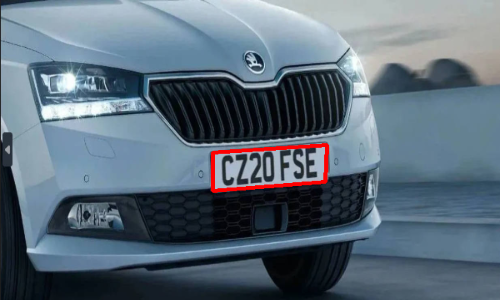

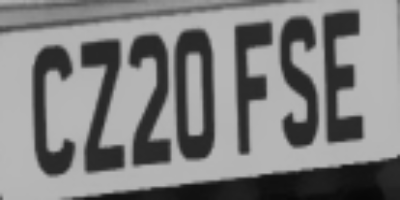

In [4]:
img = cv2.imread("image1.jpg",cv2.IMREAD_COLOR)
img = cv2.resize(img, (600,400) )

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #转换为灰度图像
gray = cv2.bilateralFilter(gray, 13, 15, 15) #对灰度图像进行双边滤波处理
#减少图像中的噪声，并保留图像的边缘信息。参数13表示滤波器的直径，15和15是色彩空间标准差和灰度值空间标准差。

#1.处理图像中的边缘，并检测其中的轮廓
edged = cv2.Canny(gray, 30, 200) #使用Canny边缘检测算法在灰度图像上检测边缘。
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #查找二进制边缘图像中的轮廓
contours = imutils.grab_contours(contours)  #使用imutils库中的 grab_contours 函数来确保获得适用于不同OpenCV版本的轮廓列表
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
#对检测到的轮廓列表进行排序，按轮廓的面积从大到小排序，并仅保留前10个最大的轮廓。
screenCnt = None #初始化变量，用于存储找到的感兴趣的轮廓（例如车牌的轮廓）

#2.迭代处理先前找到的轮廓列表 contours，以寻找可能是车牌的轮廓
for c in contours:

    peri = cv2.arcLength(c, True)#计算其周长（arc length）。True 参数表示轮廓是封闭的，因此它会考虑轮廓的闭合性。
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
#对当前轮廓 c 进行多边形逼近（approximation）。
#cv2.approxPolyDP 函数根据给定的精度参数来逼近轮廓。参数 0.018 * peri 是逼近的精度，它根据轮廓的周长计算而来。
    if len(approx) == 4:
        screenCnt = approx
        break

#3.判断是否检测到了合适的车牌轮廓，并相应地设置一个标志（detected）以指示是否检测成功
if screenCnt is None: #screenCnt 为None，意味着在之前的轮廓检测过程中没有找到合适的车牌轮廓
    detected = 0 #表示没有检测到车牌
    print ("No contour detected")
else:
     detected = 1

#4.在原始图像上绘制找到的车牌轮廓，以便可视化
if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

#5.创建一个掩码图像，然后将找到的车牌轮廓（screenCnt）填充到这个掩码图像中，最后通过按位与操作将原始图像中的车牌区域提取出来
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)

#6.从掩码图像中提取出车牌区域的像素坐标，并根据这些坐标裁剪出车牌区域的图像
(x, y) = np.where(mask == 255)  #查找掩码图像中像素值为255（白色）的坐标
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

#7.使用Tesseract OCR引擎对提取的车牌区域图像 Cropped 进行文本识别，并输出识别到的车牌号码
text = pytesseract.image_to_string(Cropped, config='--psm 11')
print("programming_fever's License Plate Recognition\n")
print("Detected license plate Number is:",text)
img = cv2.resize(img,(500,300))
Cropped = cv2.resize(Cropped,(400,200))

# 显示图像
cv2_imshow(img)
cv2_imshow(Cropped)
